# Animal Future data analysis

Notebook for the analysis of the analysis of the survey data collected in the scope of the Animal Future project for Portugal. 

**Objective**: understand which are the indicators that influenced past adoption of SBP. The goal is to replace the education level as proxy indicator for the risk aversion of farmers.

**Note**: the notebok is divided into two sections, the first with an analysis on all the 43 farmers and the second considering the additional data available only for 31 of them.

In [223]:
import pandas as pd
import numpy as np
import math
import os

In [67]:
# For plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [68]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Data ingestion

### Area use data

In [69]:
path_area_data = '../survey-data/43_Areas_POR_DualPurpose.xlsx'
columns_to_fetch = ['FARM_ID', 'AREA_ID', 'Surface']
area_data_original = pd.read_excel(path_area_data, sheet_name='Main', index_col=0, usecols=columns_to_fetch)
area_data_original = area_data_original.drop('PT00')

Get label:
* 1 if the farm has any sown permanent pasture
* 0 otherwise

In [70]:
area_data_SBP_or_not = area_data_original['AREA_ID'].str.contains('Sown permanent pasture')
area_data_SBP_or_not = area_data_SBP_or_not.groupby('FARM_ID').any()

area_data = pd.DataFrame()
area_data['AdoptedSBP'] = area_data_SBP_or_not.astype(int)

In [71]:
area_data.head()

,AdoptedSBP
FARM_ID,
PT01,0
PT02,0
PT03,1
PT04,1
PT05,0


Get total pasture area

In [72]:
area_data_original = area_data_original[area_data_original['AREA_ID'].str.contains('pasture')]
area_data['PastureSurface'] = area_data_original.groupby('FARM_ID')['Surface'].sum()

area_data.head()

,AdoptedSBP,PastureSurface
FARM_ID,,
PT01,0,60.90
PT02,0,364.00
PT03,1,3450.44
PT04,1,160.40
PT05,0,457.37


### Livestock data

In [73]:
path_animal_data = '../survey-data/43_AnimalCategories_POR_DualPurpose.xlsx'
columns_to_fetch = ['FARM_ID', 'LivestockType', 'AverageNumber']
animal_data_original = pd.read_excel(path_animal_data, sheet_name='Main', index_col=0, usecols=columns_to_fetch)
animal_data_original = animal_data_original.drop('PT00') # Drop farm 00, not relevant for the analysis

Get percentage of cattle for each farm

In [74]:
total_animals = animal_data_original.groupby('FARM_ID')['AverageNumber'].sum().rename('AverageAnimals')

total_animals_per_type = animal_data_original.groupby(['FARM_ID', 'LivestockType'], as_index=True).sum()
total_cattle = total_animals_per_type.query('LivestockType == "Cattle"').rename(columns={'AverageNumber': 'AverageCattle'})

total_animal_cattle = pd.merge(total_animals, total_cattle, on='FARM_ID', how='outer')
total_animal_cattle = total_animal_cattle.fillna(0)

In [75]:
animal_data = pd.DataFrame()
animal_data['CattlePercentage'] = total_animal_cattle['AverageCattle'] / total_animal_cattle['AverageAnimals']

animal_data.head()

,CattlePercentage
FARM_ID,
PT01,0.000000
PT02,0.000000
PT03,1.000000
PT04,1.000000
PT05,0.410191


### Location data

**Note**: 'PT35' had a white space in the excel file after the name that made it disappear when merging the datasets.

In [76]:
path_location_data = '../survey-data/Farms_Location.xls'
columns_to_fetch = ['FARM_ID', 'Distrito', 'Concelho']
# Imported without FARM_ID as index since need to be fixed before
location_data = pd.read_excel(path_location_data, usecols=columns_to_fetch) 

location_data.head()

,FARM_ID,Distrito,Concelho
0,PT1,Portalegre,Elvas
1,PT2,Setúbal,Grândola
2,PT3,Santarém,Benavente
3,PT4,Setúbal,Montijo
4,PT5,Évora,Montemor


In [77]:
num_idx = 2
for idx in range(len(location_data['FARM_ID'])):
    if len(location_data['FARM_ID'][idx]) == 3:
        location_data['FARM_ID'][idx] = location_data['FARM_ID'][idx][:num_idx] + '0' + location_data['FARM_ID'][idx][num_idx:]

In [78]:
location_data = location_data.set_index('FARM_ID')

In [79]:
location_data.head()

,Distrito,Concelho
FARM_ID,,
PT01,Portalegre,Elvas
PT02,Setúbal,Grândola
PT03,Santarém,Benavente
PT04,Setúbal,Montijo
PT05,Évora,Montemor


### Farms general data

In [80]:
path_general_data = '../survey-data/31_FarmsGeneral_DualPurpose.xlsx'
columns_to_fetch = ['FARM_ID', 'OwnLand', 'RentedLand', 'LegalForm','FarmerSince']
general_data_original = pd.read_excel(path_general_data, index_col=0, usecols=columns_to_fetch)
general_data_original = general_data_original.drop('PT00')

Get percentage of rented land over total one

In [81]:
general_data = general_data_original[['LegalForm', 'FarmerSince']]
general_data['PercentRentedLand'] = general_data_original['RentedLand'] / (general_data_original['OwnLand'] + general_data_original['RentedLand'])

c:\users\giaco\.virtualenvs\mixed-abm-phbhzcqt\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [82]:
general_data.head()

,LegalForm,FarmerSince,PercentRentedLand
FARM_ID,,,
PT02,Individual,29,0.0
PT13,Sociedade Agrícola,11,0.0
PT15,Sociedade Agrícola,11,1.0
PT16,Individual,3,1.0
PT17,Sociedade Agrícola,10,1.0


### Education data

In [83]:
path_education_data = '../survey-data/31_Social_Education_DualPurpose.xlsx'
columns_to_fetch = ['FARM_ID', 'HighestEducationalDegree', 'HighestAgriculturalEducationalDegree']
education_data = pd.read_excel(path_education_data, index_col=0, usecols=columns_to_fetch)
education_data = education_data.drop('PT00')
education_data['HighestAgriculturalEducationalDegree'] = education_data['HighestAgriculturalEducationalDegree'].fillna('None')

education_data.head()

,HighestEducationalDegree,HighestAgriculturalEducationalDegree
FARM_ID,,
PT02,Undergraduate,Undergraduate
PT13,Undergraduate,Undergraduate
PT15,Undergraduate,Undergraduate
PT16,Undergraduate,Undergraduate
PT17,Undergraduate,None


### Succession data

In [84]:
path_succession_data = '../survey-data/31_Social_Succession_DualPurpose.xlsx'
columns_to_fetch = ['FARM_ID', 'ExpectationFarmSuccession']
succession_data_original = pd.read_excel(path_succession_data, index_col=0, usecols=columns_to_fetch)
succession_data_original = succession_data_original.drop('PT00')

In [85]:
succession_data_original['ExpectationFarmSuccession'].value_counts()

2    20
1     9
5     1
Name: ExpectationFarmSuccession, dtype: int64

Since in the data we have just farmers that either expect a family succession or not (and one answer as "other"), we transform this feature in a binary one, either if family succession is expected or not

In [86]:
succession_data=pd.DataFrame()
mapping = {1: 0, 2: 1, 5: 0}
succession_data['ExpectationFamilySuccession'] = succession_data_original['ExpectationFarmSuccession'].replace(mapping)

succession_data.head()

,ExpectationFamilySuccession
FARM_ID,
PT02,1
PT13,1
PT15,1
PT16,1
PT17,1


In [87]:
## Old verion with categorical attribute

#mapping = {1: 'NoExpectation', 2: 'FamilyInheritance', 5: 'NoExpectation'}
## Since we have only one instance that answered 5 (that would be 'Other'), we make it fall in the category NoExpectation
#succession_data['ExpectationFarmSuccession'] = succession_data_original['ExpectationFarmSuccession'].replace(mapping)

#succession_data.head()

# Analysis on data for 30 farmers

In [220]:
import functools

In [221]:
farms_dataframes = [area_data, animal_data, location_data, general_data, education_data, succession_data]
farms30 = functools.reduce(lambda left, right: pd.merge(left, right, on='FARM_ID'), farms_dataframes)

farms30.head()

,AdoptedSBP,PastureSurface,CattlePercentage,Distrito,Concelho,LegalForm,FarmerSince,PercentRentedLand,HighestEducationalDegree,HighestAgriculturalEducationalDegree,ExpectationFamilySuccession
FARM_ID,,,,,,,,,,,
PT02,0,364.00,0.0,Setúbal,Grândola,Individual,29,0.0,Undergraduate,Undergraduate,1
PT13,1,542.58,1.0,Portalegre,Avis,Sociedade Agrícola,11,0.0,Undergraduate,Undergraduate,1
PT15,1,262.70,1.0,Portalegre,Monforte,Sociedade Agrícola,11,1.0,Undergraduate,Undergraduate,1
PT16,0,23.00,1.0,Évora,Évora,Individual,3,1.0,Undergraduate,Undergraduate,1
PT17,1,250.00,1.0,Évora,Montemor,Sociedade Agrícola,10,1.0,Undergraduate,None,1


## Data exploration

In [90]:
farms30.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, PT02 to PT43
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   AdoptedSBP                            30 non-null     int32  
 1   PastureSurface                        30 non-null     float64
 2   CattlePercentage                      30 non-null     float64
 3   Distrito                              30 non-null     object 
 4   Concelho                              30 non-null     object 
 5   LegalForm                             30 non-null     object 
 6   FarmerSince                           30 non-null     int64  
 7   PercentRentedLand                     30 non-null     float64
 8   HighestEducationalDegree              30 non-null     object 
 9   HighestAgriculturalEducationalDegree  30 non-null     object 
 10  ExpectationFamilySuccession           30 non-null     int64  
dtypes: float64(3), int32(

### Numerical attributes

In [91]:
farms30.describe()

,AdoptedSBP,PastureSurface,CattlePercentage,FarmerSince,PercentRentedLand,ExpectationFamilySuccession
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.566667,509.447667,0.810436,16.033333,0.248616,0.666667
std,0.504007,618.480397,0.346573,11.505571,0.411126,0.479463
min,0.000000,23.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,141.250000,0.739726,8.000000,0.000000,0.000000
50%,1.000000,316.000000,1.000000,11.000000,0.000000,1.000000
75%,1.000000,424.920000,1.000000,25.750000,0.371753,1.000000
max,1.000000,2500.000000,1.000000,40.000000,1.000000,1.000000


Saving figure Numerical Attributes_Histograms


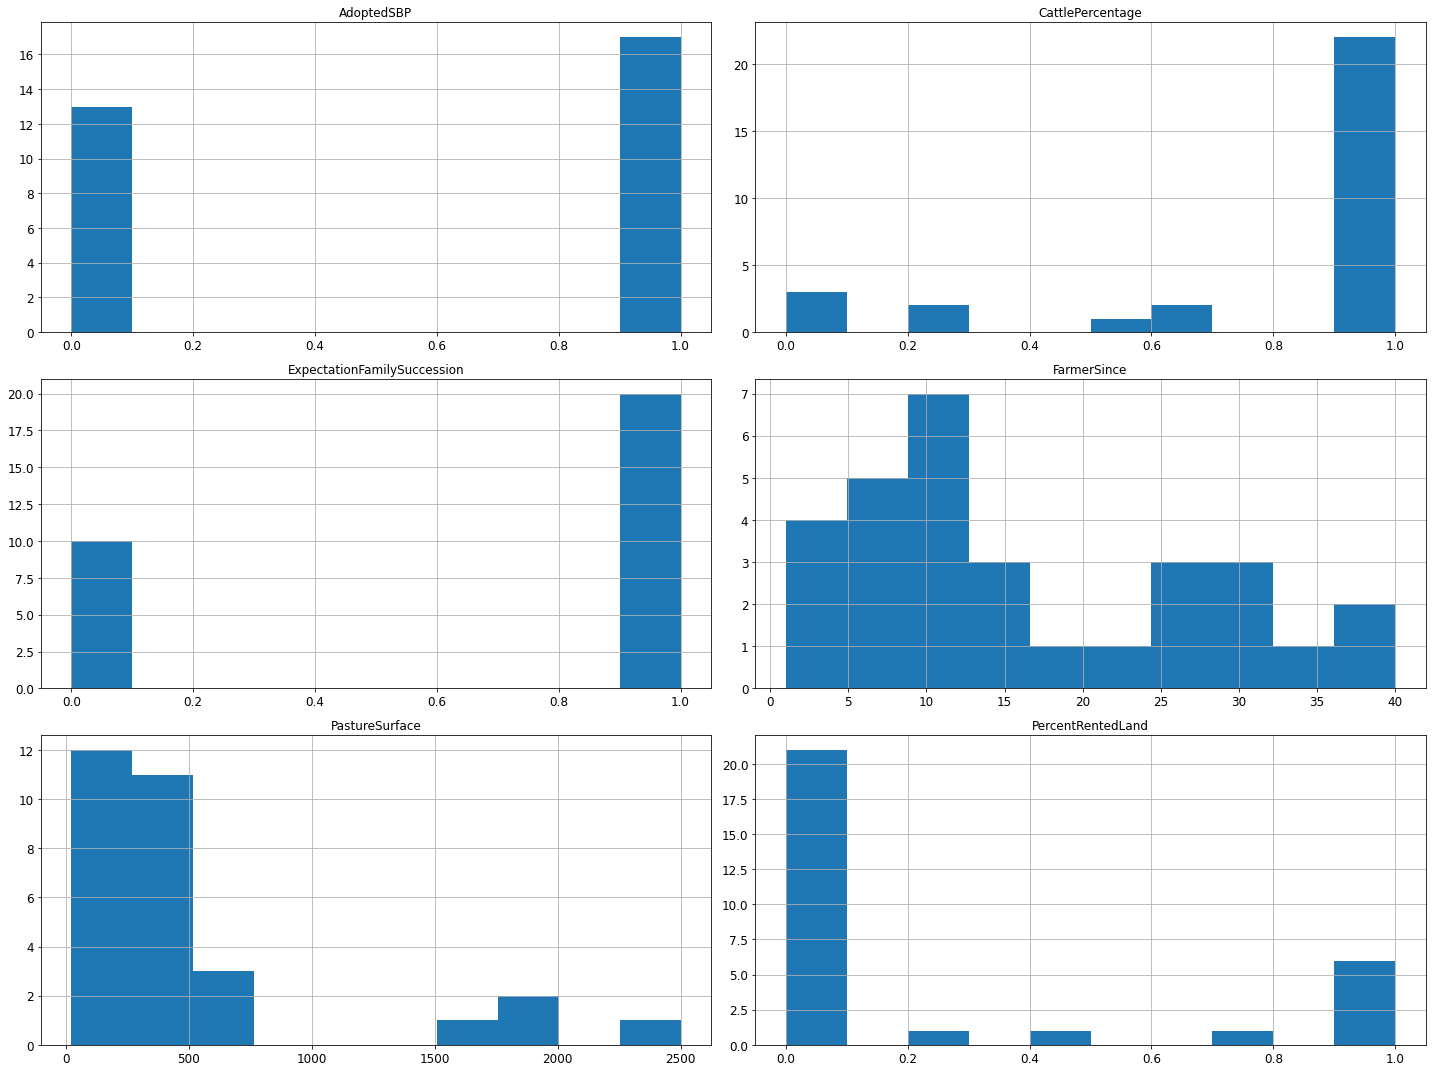

In [92]:
farms30.hist(figsize=(20,15))
save_fig('Numerical Attributes_Histograms')

#### Correlations

In [174]:
numerical_attributes = ['AdoptedSBP', 'PastureSurface', 'CattlePercentage', 'FarmerSince', 'PercentRentedLand', 'ExpectationFamilySuccession']

In [94]:
corr_matrix = farms30.corr()
corr_matrix

,AdoptedSBP,PastureSurface,CattlePercentage,FarmerSince,PercentRentedLand,ExpectationFamilySuccession
AdoptedSBP,1.000000,0.157472,-0.044237,0.002577,-0.193404,0.095130
PastureSurface,0.157472,1.000000,-0.024826,-0.008405,-0.152965,0.059414
CattlePercentage,-0.044237,-0.024826,1.000000,-0.161004,0.124918,0.116587
FarmerSince,0.002577,-0.008405,-0.161004,1.000000,-0.404618,0.277121
PercentRentedLand,-0.193404,-0.152965,0.124918,-0.404618,1.000000,-0.089888
ExpectationFamilySuccession,0.095130,0.059414,0.116587,0.277121,-0.089888,1.000000


In [95]:
corr_matrix['AdoptedSBP'].sort_values(ascending=False)

AdoptedSBP                     1.000000
PastureSurface                 0.157472
ExpectationFamilySuccession    0.095130
FarmerSince                    0.002577
CattlePercentage              -0.044237
PercentRentedLand             -0.193404
Name: AdoptedSBP, dtype: float64

Saving figure Numerical Attributes_Correlation Matrix


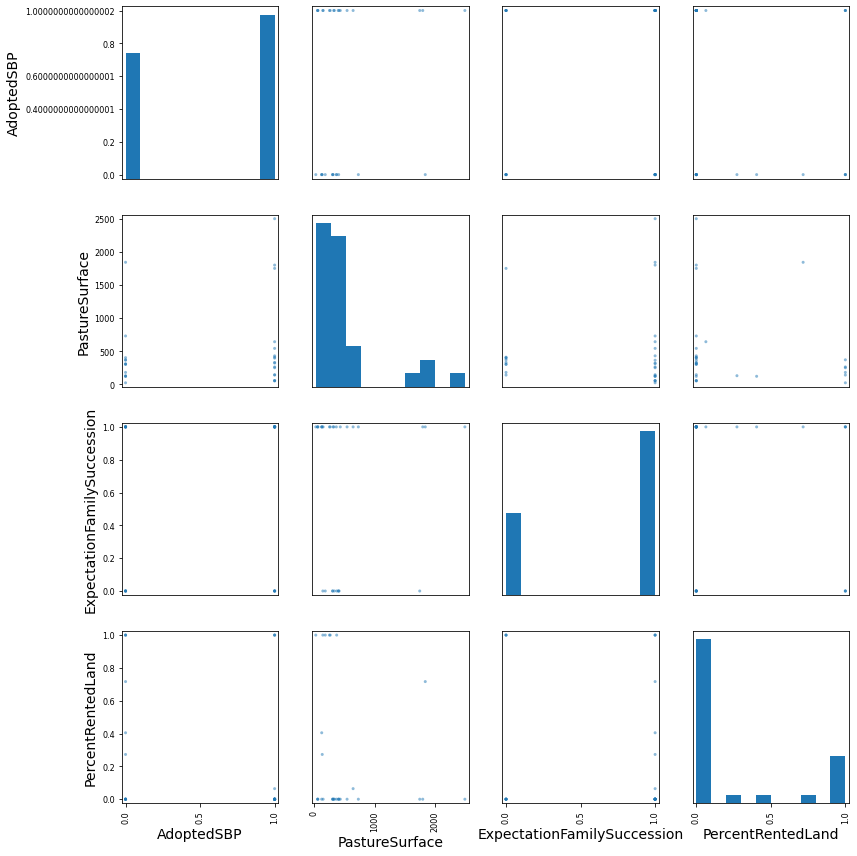

In [96]:
from pandas.plotting import scatter_matrix

scatter_matrix(farms30[['AdoptedSBP', 'PastureSurface', 'ExpectationFamilySuccession', 'PercentRentedLand']], figsize=(12, 12))
save_fig('Numerical Attributes_Correlation Matrix')

## Categorical attributes

In [125]:
categorical_attributes = ['Distrito', 'Concelho', 'LegalForm', 'HighestEducationalDegree', 
                          'HighestAgriculturalEducationalDegree']

In [100]:
for cat_attr in categorical_attributes:
    print(farms30[cat_attr].value_counts())
    print("")

Évora         13
Beja           8
Portalegre     4
Setúbal        4
Santarém       1
Name: Distrito, dtype: int64

Montemor                6
Évora                   5
Beja                    2
Aljustrel               1
Montijo                 1
Alcácer do Sal          1
Portel                  1
Castro Verde            1
Monforte                1
Alvito                  1
Avis                    1
Santiago do Cacém       1
Ourique                 1
Arraiolos               1
Ferreira do Alentejo    1
Arronches               1
Coruche                 1
Serpa                   1
Elvas                   1
Grândola                1
Name: Concelho, dtype: int64

Sociedade Agrícola    20
Individual             8
ENI                    1
Cooperativa Social     1
Name: LegalForm, dtype: int64

Undergraduate    14
Graduate         13
Secondary         2
Primary           1
Name: HighestEducationalDegree, dtype: int64

Undergraduate    13
Graduate         11
None              6
Name: HighestAgric

Saving figure Categorical Attributes_Stacked Histograms


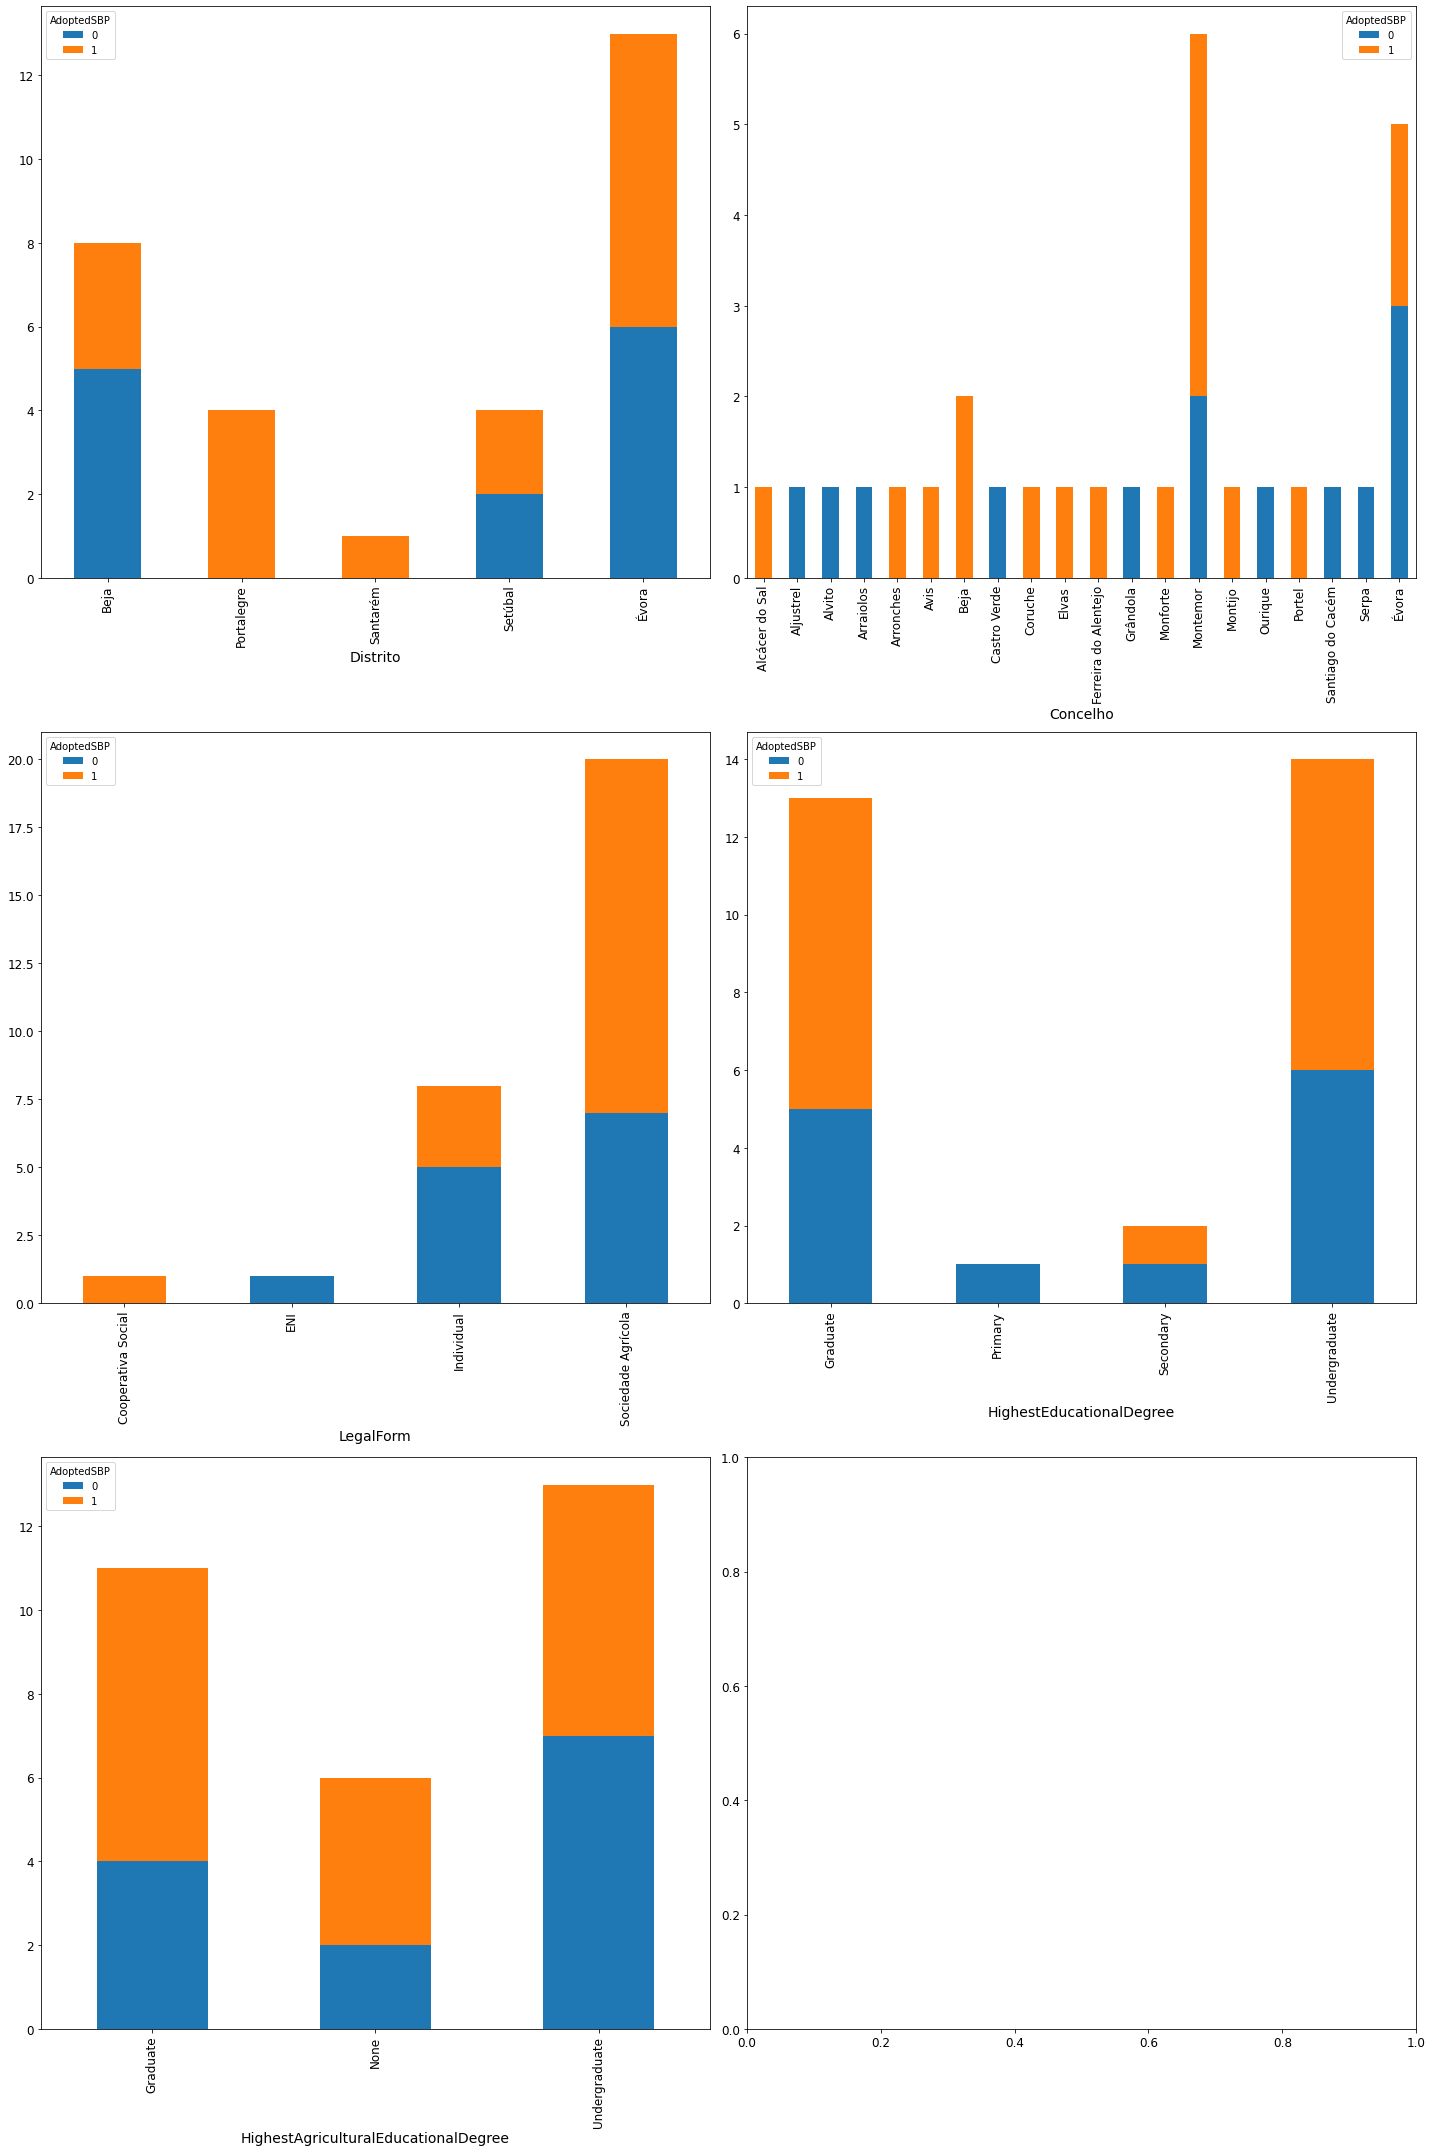

In [222]:
fig, axes = plt.subplots(math.ceil(len(categorical_attributes)/2), ncols=2, figsize=(20, 30))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.4)
axes = axes.flatten()
i = 0

for cat_attr in categorical_attributes:
    hist = farms30.groupby(cat_attr)['AdoptedSBP'].value_counts().unstack().plot(ax=axes[i], kind='bar', stacked=True)
    i += 1
    
save_fig('Categorical Attributes_Stacked Histograms')

### Drop unusable data

In [102]:
farms30 = farms30.drop('Concelho', axis=1) # Too many
farms30 = farms30.drop('HighestAgriculturalEducationalDegree', axis=1) # Redundant with HighestEducationalDegree

## Splitting the data

**Improvement**: performe stratified sampling

In [103]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(farms30, test_size=0.2, random_state=42)

## Data preparation

In [201]:
farms = train_set.drop('AdoptedSBP', axis=1)
farms_labels = train_set['AdoptedSBP'].copy()

### Handling categorical attributes

#### Ordinal econding

In [117]:
farms_ordinal_attributes = ['HighestEducationalDegree']
farms_ordinal_cat = farms[farms_ordinal_attributes]
farms_ordinal_cat[:5]

,HighestEducationalDegree
FARM_ID,
PT42,Undergraduate
PT38,Undergraduate
PT25,Primary
PT02,Undergraduate
PT17,Undergraduate


In [149]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder(categories=[['Primary', 'Secondary', 'Undergraduate', 'Graduate']])
farms_ordinal_cat_encoded = ordinal_encoder.fit_transform(farms_ordinal_cat)

farms_ordinal_cat_encoded[:5]

[['Primary', 'Secondary', 'Undergraduate', 'Graduate']]

#### One-hot encoding

In [118]:
farms_onehot_attributes = ['Distrito', 'LegalForm']
farms_onehot_cat = farms[farms_onehot_attributes]

farms_onehot_cat.head()

,Distrito,LegalForm
FARM_ID,,
PT42,Setúbal,Sociedade Agrícola
PT38,Évora,Sociedade Agrícola
PT25,Beja,Individual
PT02,Setúbal,Individual
PT17,Évora,Sociedade Agrícola


In [115]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder()
farms_onehot_cat_encoded = onehot_encoder.fit_transform(farms_onehot_cat)

farms_onehot_cat_encoded.toarray()

array([[0., 0., 0., 1., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 1.],
       [1.

In [165]:
onehot_encoder.categories_

[array(['Beja', 'Portalegre', 'Santarém', 'Setúbal', 'Évora'], dtype=object),
 array(['Cooperativa Social', 'ENI', 'Individual', 'Sociedade Agrícola'],
       dtype=object)]

### Preparation pipeline

In [112]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [183]:
[attr for attr in numerical_attributes if attr != 'AdoptedSBP']

['PastureSurface',
 'CattlePercentage',
 'FarmerSince',
 'PercentRentedLand',
 'ExpectationFamilySuccession']

In [134]:
preparation_pipeline = ColumnTransformer([
    ('num', StandardScaler(), [attr for attr in numerical_attributes if attr != 'AdoptedSBP']),
    ('ord_cat', ordinal_encoder, farms_ordinal_attributes),
    ('onehot_cat', onehot_encoder, farms_onehot_attributes)
])

In [198]:
farms_prepared = preparation_pipeline.fit_transform(farms)

In [237]:
# Print prepared data as a DataFrame
attributes = [attr for attr in numerical_attributes if attr != 'AdoptedSBP'] + farms_ordinal_attributes
for cat_name in onehot_encoder.categories_:
    attributes += cat_name.tolist()   
pd.DataFrame(farms_prepared, columns=attributes, index=farms.index).head()

,PastureSurface,CattlePercentage,FarmerSince,PercentRentedLand,ExpectationFamilySuccession,HighestEducationalDegree,Beja,Portalegre,Santarém,Setúbal,Évora,Cooperativa Social,ENI,Individual,Sociedade Agrícola
FARM_ID,,,,,,,,,,,,,,,
PT42,-0.345130,-0.430043,1.563341,-0.612880,-1.290994,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
PT38,-0.204910,0.647537,-0.609320,-0.612880,-1.290994,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
PT25,-0.638358,0.647537,-0.776448,1.816889,-1.290994,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
PT02,-0.280715,-2.085207,0.978394,-0.612880,0.774597,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
PT17,-0.502298,0.647537,-0.609320,1.816889,0.774597,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## Train model

In [204]:
from sklearn.linear_model import LogisticRegression

logit_regr = LogisticRegression()
logit_regr.fit(farms_prepared, farms_labels)

LogisticRegression()

In [208]:
some_data = farms_prepared[:5]
some_labels = farms_labels.iloc[:5]
print('Predict:', logit_regr.predict(some_data))
print('Labels:', some_labels)

Predict: [1 1 0 1 0]
Labels: FARM_ID
PT42    1
PT38    0
PT25    0
PT02    0
PT17    1
Name: AdoptedSBP, dtype: int32


### Logit regression with l2 regul

In [241]:
farms_prepared.shape

(24, 15)

In [244]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(logit_regr, farms_prepared, farms_labels, scoring='neg_mean_squared_error', cv=11)
logit_rmse_scores = np.sqrt(-scores)

In [245]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(logit_rmse_scores)

Scores: [1.         0.81649658 1.         0.         0.70710678 0.70710678
 0.         1.         0.70710678 0.         1.        ]
Mean: 0.6307106294988517
Standard deviation: 0.40349741318033605


In [265]:
for attr, coef in zip(attributes, logit_regr.coef_.tolist()[0]):
    print(coef, attr)

-0.040998020790186766 PastureSurface
-0.28561441266131393 CattlePercentage
-0.28826996898521623 FarmerSince
-0.48606763629712313 PercentRentedLand
0.30186416338287947 ExpectationFamilySuccession
-0.0547999380653788 HighestEducationalDegree
-0.7115856105941215 Beja
0.8155048059270821 Portalegre
0.19584429855552257 Santarém
-0.0995142450689616 Setúbal
-0.20024673797790862 Évora
0.3747816827294384 Cooperativa Social
-0.2590614748617053 ENI
-0.6051999108165419 Individual
0.4894822137904213 Sociedade Agrícola


### Logit regression with l1 regul

In [256]:
logit_regr_l1 = LogisticRegression(penalty='l1', solver='liblinear')
scores_l1 = cross_val_score(logit_regr_l1, farms_prepared, farms_labels, scoring='neg_mean_squared_error', cv=11)
logit_l1_rmse_scores = np.sqrt(-scores_l1)
display_scores(logit_l1_rmse_scores)

Scores: [0.81649658 0.57735027 1.         0.70710678 1.         0.70710678
 0.         1.         1.         0.70710678 1.        ]
Mean: 0.7741061085160904
Standard deviation: 0.2873637321866778


In [267]:
logit_regr_l1.fit(farms_prepared, farms_labels)

LogisticRegression(penalty='l1', solver='liblinear')

In [269]:
for attr, coef in zip(attributes, logit_regr_l1.coef_.tolist()[0]):
    print(coef, attr)

0.0 PastureSurface
-0.11995367235733831 CattlePercentage
0.0 FarmerSince
-0.2883377532156174 PercentRentedLand
0.016950842422446103 ExpectationFamilySuccession
0.0 HighestEducationalDegree
-0.38310865486644047 Beja
0.9523828249311084 Portalegre
0.0 Santarém
0.0 Setúbal
0.0 Évora
0.0 Cooperativa Social
0.0 ENI
-0.16130436259588019 Individual
0.24175717429604218 Sociedade Agrícola


## Results analysis

**Observations on results**: 
* The results are really bad.
* Some things really do not make sense, as the negative and really low score for the PastureSurface
* The coefficients are all pretty close with the l2.
* The l1 performs worse, but also maybe beacuse give a lot of importance to the belonging of one municipality

**Possible errors**:
* Using each municipality separately makes sense? They are mutually exclusive but also in Hands On it does like this
